In [1]:
import pandas as pd

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [18]:
data = pd.read_csv("clean.csv")
data

,disposition,period,duration,depth,planet_radius,stellar_temperature,stellar_gravity,stellar_radius,magnitude,snr,equilibrium_temp
0,1,9.488036,2.957500,615.800000,2.260000,5455.0,4.467,0.927000,15.3470,35.800000,793.000000
1,1,54.418383,4.507000,874.800000,2.830000,5455.0,4.467,0.927000,15.3470,25.800000,443.000000
2,2,19.899140,1.782200,10829.000000,14.600000,5853.0,4.544,0.868000,15.4360,76.300000,638.000000
3,0,1.736952,2.406410,8079.200000,33.460000,5805.0,4.564,0.791000,15.5970,505.600000,1395.000000
4,1,2.525592,1.654500,603.300000,2.750000,6031.0,4.438,1.046000,15.5090,40.900000,1406.000000
...,...,...,...,...,...,...,...,...,...,...,...
17258,0,3.443800,2.572000,7260.750000,NaN,4805.2,NaN,NaN,10.0781,700.502570,1708.000000
17259,0,14.537800,6.826000,4040.000000,16.052300,8007.0,NaN,2.050000,9.7925,248.787327,NaN
17260,0,8.413486,3.556833,17479.605330,20.510696,5786.0,4.520,0.926261,9.7727,1345.822421,857.731431
17261,0,0.941436,1.360700,339.912662,4.529209,8322.0,4.010,2.349860,9.6952,50.328179,3641.626449


In [19]:
X = data.drop("disposition", axis=1)
Y = data["disposition"]

X = X.fillna(0)

X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((13810, 10), (3453, 10), (13810,), (3453,))

In [ ]:
model = XGBClassifier(
    n_estimators=1050, 
    learning_rate=0.01,
    max_depth=10,
    subsample=0.5,                  #0.5
    colsample_bytree=0.8,
    reg_lambda=1.46,                 #1.46
    random_state=42,
    tree_method="hist",
    eval_metric="mlogloss"
)

model.fit(X_train, y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [6]:
import pickle

# save
with open('model.pkl','wb') as f:
    pickle.dump(model,f)

Accuracy: 0.7717926440776137
              precision    recall  f1-score   support

  Not planet       0.81      0.75      0.78      1225
      Planet       0.78      0.77      0.78       808
   Candidate       0.74      0.79      0.76      1420

    accuracy                           0.77      3453
   macro avg       0.78      0.77      0.77      3453
weighted avg       0.77      0.77      0.77      3453



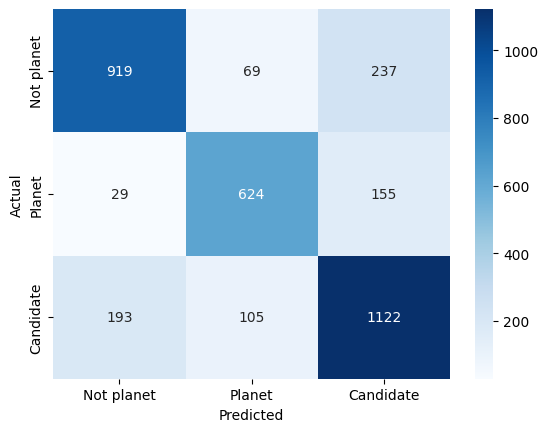

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

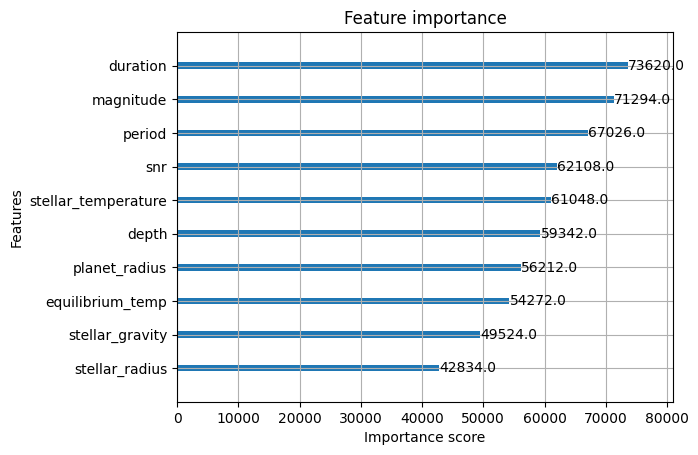

In [ ]:
# Predictions
y_pred = model.predict(X_valid)
y_proba = model.predict_proba(X_valid)

# Metrics
print("Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred, target_names=["Not planet", "Planet", "Candidate"]))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not planet","Planet","Candidate"],
            yticklabels=["Not planet","Planet","Candidate"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Feature Importance
from xgboost import plot_importance
plot_importance(model)

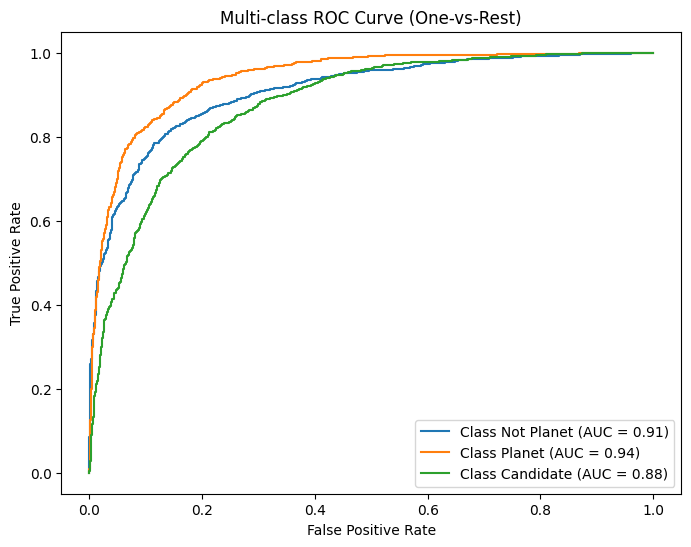

Micro-averaged AUC: 0.9124677131802352


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

classes = [0, 1, 2]
labels = ["Not Planet", "Planet", "Candidate"]


# Binarize labels for One-vs-Rest
y_test_bin = label_binarize(y_valid, classes=classes)

# Predict probabilities 
y_score = model.predict_proba(X_valid)

# Plot ROC curve for each class
plt.figure(figsize=(8,6))
for i, class_label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve (One-vs-Rest)")
plt.legend()
plt.show()


micro_roc_auc = roc_auc_score(y_test_bin, y_score, average="micro")
print("Micro-averaged AUC:", micro_roc_auc)